In [ ]:
import pandas as pd
import numpy as np
import tensorflow 
from tensorflow import keras
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, \
    concatenate
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt


df_train = pd.read_csv("/content/drive/MyDrive/ecg/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1)
df_test = pd.read_csv("/content/drive/MyDrive/ecg/mitbih_test.csv", header=None)

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]


### Displaying the shapes of training and testing data

In [ ]:
print(X.shape) 
print(Y.shape) 
print(X_test.shape) 
print(Y_test.shape)

(87554, 187, 1)
(87554,)
(21892, 187, 1)
(21892,)


### Applying ResNet 
### Defining the residual and the convolutional block

In [ ]:
# create residual and convolutional block 
class Residual_block:
    kernel_size = 3
    strides = 1
    padding = 'same'
    data_format = "channels_last"    
    def __init__(self, x, x_shortcut, filters):
        self.x = x 
        self.filters = filters
        self.x_shortcut = x_shortcut 
        
    def unit(self):
        x = Conv1D(self.filters, self.kernel_size, self.strides, self.padding, self.data_format)(self.x) 
        x = Activation('relu')(x)
        x = Conv1D(self.filters, self.kernel_size, self.strides, self.padding, self.data_format)(x)
        x = Activation('linear')(x)
        # add skip connection
        if x.shape[1:] == self.x_shortcut.shape[1:]:
            x = Add()([x, self.x_shortcut])
        else:
            raise Exception('Skip Connection Failiure!')
        return x
class Convolution_block:
    kernel_size = 1
    strides = 1
    padding = 'same'
    data_format = "channels_last"
    
    def __init__(self, x, filters):
        self.x = x
        self.filters = filters
        
    def unit(self):
        x = Conv1D(self.filters, self.kernel_size, self.strides, self.padding, self.data_format)(self.x) 
        x = Activation('linear')(x)
        return x

### Defining the residual stack

In [ ]:
# create residual stack 
def residual_stack(x, filters):
    x = Convolution_block(x, filters)
    print('x')
    print(x)
    x = x.unit()
    print('xunit')
    print(x)
    
    x_shortcut = x
    x = Residual_block(x, x_shortcut, filters)
    x = x.unit() 
    x_shortcut = x 
    x = Residual_block(x, x_shortcut, filters)
    x = x.unit()
    
    # max pooling layer
    x = MaxPooling1D(pool_size = 2, strides = None, padding='valid', data_format = 'channels_last')(x)
    return x

### Making ResNet

In [ ]:
# define resnet model 
def ResNet(input_shape, classes):
    x_input = Input(input_shape)
    x = x_input 
    # residual stack 
    num_filters = 40 
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    x = residual_stack(x, num_filters)
    # output layer 
    x = Flatten()(x)
    x = Dense(128, activation='selu', kernel_initializer = "he_normal")(x)
    x = Dropout(.5)(x)
    x = Dense(128, activation="selu", kernel_initializer="he_normal")(x)
    x = Dropout(.5)(x)
    x = Dense(classes, activation="softmax", kernel_initializer=glorot_uniform(seed=0))(x)
    # create the model
    model = Model(inputs=x_input, outputs=x)
    return model

### Saving model weights and history

In [ ]:
# option to save model weights and history 
saved_model = False
saved_history = False
# create directory for model weights
if saved_model is True:
    weights_path = input("Name model weights directory: ")
    weights_path = "data/weights/" + weights_path 
    try:
        os.mkdir(weights_path)
    except OSError:
        print("Creation of the directory % failed" % weights_path)
    else:
        print("Successfully created the directory %s " % weights_path)
    print('\n')
# create directory for model history
if saved_history is True:
    history_path = input("Name model history directory: ")
    history_path = "data/model_history/" + history_path
    try:
        os.mkdir(history_path)
    except OSError:
        print("Creation of the directoy failed" % history_path)
    else:
        print("Successfully created the directory" % history_path)
    print('\n')

In [ ]:
import tensorflow
from tensorflow import keras 
from tensorflow.keras.optimizers import Adam
import zipfile
# from google.colab import files
import os
from sklearn.model_selection import train_test_split
import numpy as np
import keras
from keras import layers
from tensorflow.keras.utils import to_categorical
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.layers import Input, Dropout, Add, Dense, Reshape, Activation
from keras.layers import BatchNormalization, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam

### Initializing the parameters for ResNet

In [ ]:
# initialize the optimizer 
adm = Adam(learning_rate = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.0, amsgrad = False)
# set number of epochs 
num_epochs = int(input('Enter the number of epochs: '))
# set batch size 
batch = 32
# configure weights save
if saved_model is True:
    filepath = weights_path + "/{epoch}.hdf5"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode="auto")
    callbacks_list = [checkpoint]
else:
    callbacks_list = []

Enter the number of epochs: 50


### Model compilation and fitting

In [ ]:
# initialize and train model
model = ResNet((187,1), 5)
model.compile(optimizer=adm, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary() 
history = model.fit(X, Y, epochs=num_epochs, batch_size = batch, callbacks=callbacks_list, validation_data=(X_test, Y_test))

x
xunit
KerasTensor(type_spec=TensorSpec(shape=(None, 187, 40), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'activation'")
x
xunit
KerasTensor(type_spec=TensorSpec(shape=(None, 93, 40), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'activation_5'")
x
xunit
KerasTensor(type_spec=TensorSpec(shape=(None, 46, 40), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'activation_10'")
x
xunit
KerasTensor(type_spec=TensorSpec(shape=(None, 23, 40), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'activation_15'")
x
xunit
KerasTensor(type_spec=TensorSpec(shape=(None, 11, 40), dtype=tf.float32, name=None), name='Placeholder:0', description="created by layer 'activation_20'")
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected

### Model graphs & confusion matrix
### Loss and accuracy graph

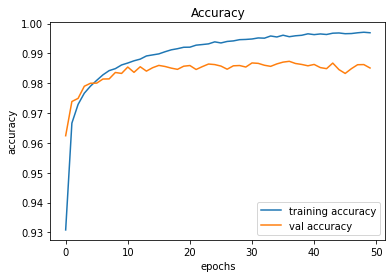

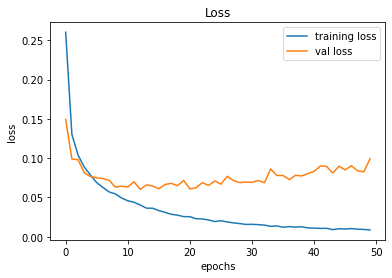

In [ ]:
plt.figure(0)
plt.plot(model.history.history['accuracy'], label='training accuracy')
plt.plot(model.history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(model.history.history['loss'], label='training loss')
plt.plot(model.history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
#Make predictions
y_probs = model.predict(X_test)

#Convert prediction probabilities into integers
y_preds = y_probs.argmax(axis=1)

685/685 [==============================] - 3s 4ms/step


Normalized confusion matrix


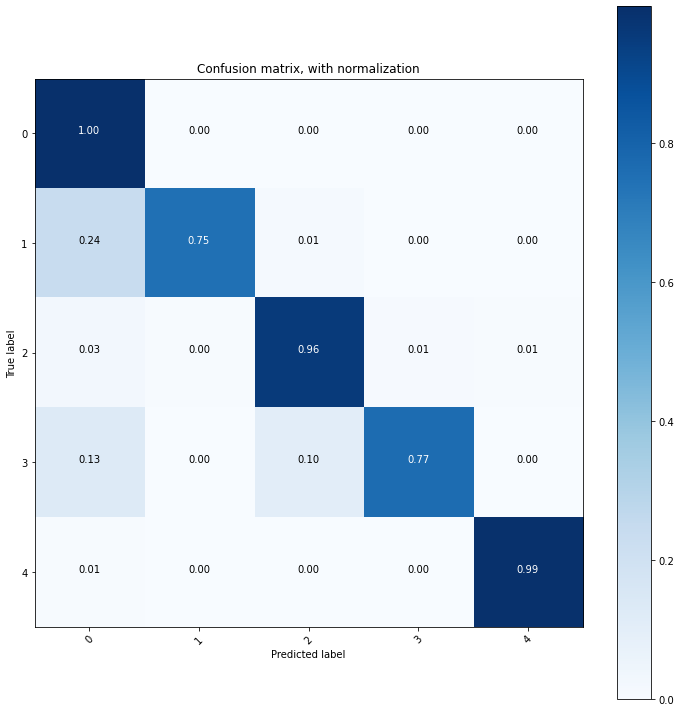

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, y_preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=classes,normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

### Applying CNN (Convolutional Neural Network)

In [ ]:
def get_model():
    nclass = 5
    inp = Input(shape=(187, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3_mitbih")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = tensorflow.keras.optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

model = get_model()
file_path = "baseline_cnn_mitbih.h5"
checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=1)
callbacks_list = [checkpoint, early, redonplat]  # early

history = model.fit(X, Y, epochs=1000, verbose=1, callbacks=callbacks_list, validation_split=0.1)
model.load_weights(file_path)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 conv1d_25 (Conv1D)          (None, 183, 16)           96        
                                                                 
 conv1d_26 (Conv1D)          (None, 179, 16)           1296      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 89, 16)           0         
 1D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 89, 16)            0         
                                                                 
 conv1d_27 (Conv1D)          (None, 87, 32)            1568      
                                                           

### Accuracy & Loss Graphs

In [ ]:
import matplotlib.pyplot as plt 
import tensorflow 
from tensorflow import keras

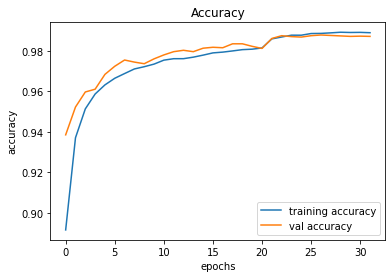

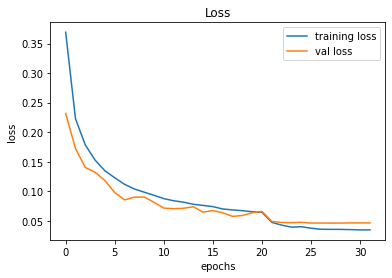

In [ ]:
plt.figure(0)
plt.plot(model.history.history['acc'], label='training accuracy')
plt.plot(model.history.history['val_acc'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(model.history.history['loss'], label='training loss')
plt.plot(model.history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay, confusion_matrix

In [ ]:
classes = ["0", "1", "2", "3", "4"]

In [ ]:
#Make predictions
y_probs = model.predict(X_test)

#Convert prediction probabilities into integers
y_preds = y_probs.argmax(axis=1)

685/685 [==============================] - 2s 3ms/step


Normalized confusion matrix


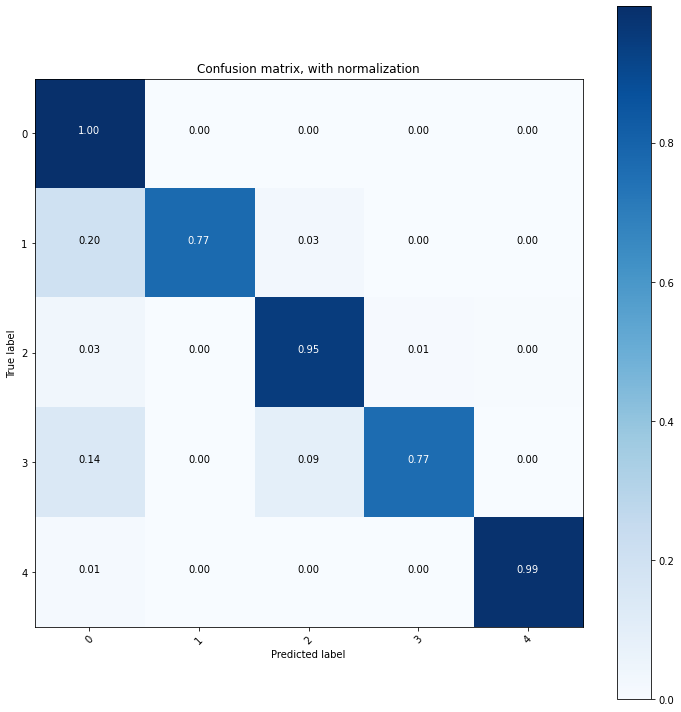

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(Y_test, y_preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=classes,normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

In [ ]:
!pip install keras-layer-normalization